# Métodos de suavización exponencial (ES)

### Por: Carolina Diartt G.

In [1]:
import requests
import statsmodels.api as sm
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

In [2]:
sns.set_style("darkgrid")

In [3]:
DATA_URL="http://robjhyndman.com/tsdldata/data/nybirths.dat"
fopen = requests.get(DATA_URL).content
ds=pd.read_csv(io.StringIO(fopen.decode('utf-8')),  header=None, names=['birthcount'])
ds.head()

,birthcount
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


In [4]:
date=pd.date_range("1946-01-01", "1959-12-31", freq="1M") # defino fecha inicial y final. Contruyo lista de fechas mensuales
ds['Date']=pd.DataFrame(date) #coloco las fehcas en las columnas
ds = ds.set_index('Date')

In [5]:
ds.index = pd.to_datetime(ds.index)

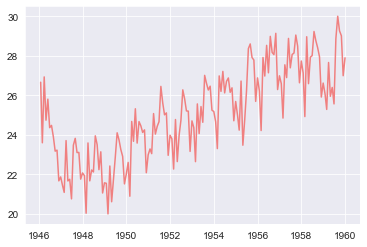

In [39]:
plt.plot(ds.birthcount, color='lightcoral');

Si se mira la amplitud de la primera componente del gráfico, veo que es más pequeña que las últimas. Cuando la amplitud de la componente estacional aumenta con el tiempo, estamos hablando de serie de tiempo multiplicativa. Si se mantuviera constante la componente estacional seria aditiva. Esto es verificable con el cálculo de la varianza de cada componente.

In [7]:
ds['Y'] = ds.index.strftime('%Y') #saco mes
ds['M'] = ds.index.strftime('%m') #saco año
ds.sort_values(['Y', 'M'], inplace=True)
ds.head()

,birthcount,Y,M
Date,,,
1946-01-31,26.663,1946,01
1946-02-28,23.598,1946,02
1946-03-31,26.931,1946,03
1946-04-30,24.740,1946,04
1946-05-31,25.806,1946,05


In [8]:
seasonal_ds = ds.groupby(by=['Y'])['birthcount'].aggregate([np.var]) #agrupo por la columna creada en el código anterior
seasonal_ds.columns = ['monthly_var'] #calculo para cada año de nacimientos la varianza

In [9]:
seasonal_ds.head(12) #varianza anual

,monthly_var
Y,
1946,2.797090
1947,1.147153
1948,1.298705
1949,1.509602
1950,1.607289
1951,1.133515
1952,1.531063
1953,1.538384
1954,1.332923


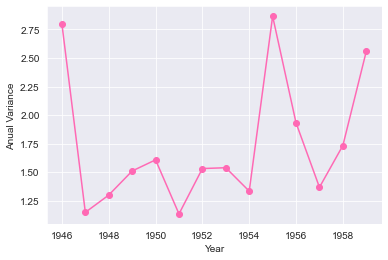

In [37]:
seasonal_ds.monthly_var.plot(color='#FF69B4', marker="o") # en este gráfico se comprueba que la varianza no es constante
plt.xlabel('Year')
plt.ylabel('Anual Variance');

In [11]:
figure_kwargs = {'figsize': (6, 6)}

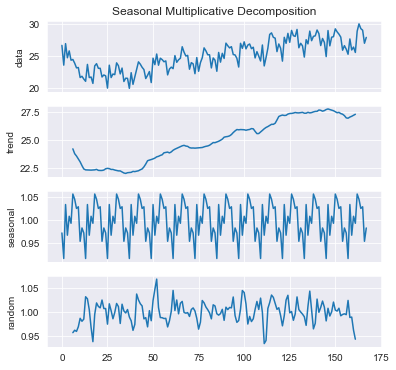

In [43]:
decomposed = arima.decompose(ds.birthcount.values, 'multiplicative', m=12)
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Seasonal Multiplicative Decomposition");

Primer panel del gráfico es la original: componente multiplicativa; estacionalidad multiplicativa. Segundo panel del grafico es la Ft o tendencia (va marcando la suavizacion que aproxima la serie de tiempo). El ultimo panel del grafico es el error, el cual estará alrededor de cero pues la componente estacional es multiplicativa. Tercer panel del gráfico es el residual que obtengo de dividir yt/ft. ft puede ser estimado con una media movil con cierta ventana.

In [13]:
import datetime

In [14]:
dates_airpass = pd.date_range(start='1949-01', periods=len(datasets.load_airpassengers()), freq='M').strftime('%Y-%m') #datos con frecuencia mensual
air_pass_df = pd.DataFrame({'Date': dates_airpass.tolist(),
                            'Passengers': datasets.load_airpassengers().tolist()}) #construyendo las fechas
air_pass_df.head(8)

,Date,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
5,1949-06,135.0
6,1949-07,148.0
7,1949-08,148.0


In [15]:
beer_aust = pd.read_csv('datasets/quarterly-beer-production-in-aus-March 1956-June 1994.csv')
beer_aust.rename(columns={"Quarterly beer production in Australia: megalitres. March 1956 ? June 1994": "beer_prod"}, inplace=True) #cambio nombre de columna
beer_aust.head(10)

,Quarter,beer_prod
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0
5,1957Q2,227.9
6,1957Q3,236.1
7,1957Q4,320.4
8,1958Q1,271.9
9,1958Q2,232.8


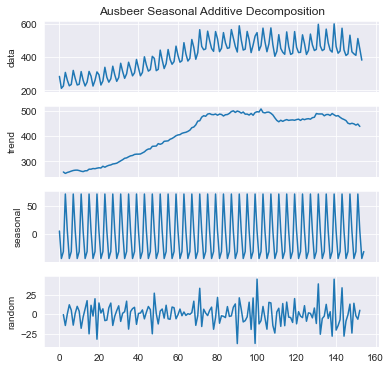

In [16]:
decomposed = arima.decompose(beer_aust.beer_prod, 'additive', m=4)
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Ausbeer Seasonal Additive Decomposition");

Segundo panel del gráfico : serie que marca la tendencia. Componentes estacionales mantienen su amplitud a través del tiempo (componente aditivo). Tercer panel del grafico: Serie que marca la estacionalidad. Error que no permite que segundo y tercer grafico sumados me den el primer panel, se presenta en el panel 4 del gráfico.

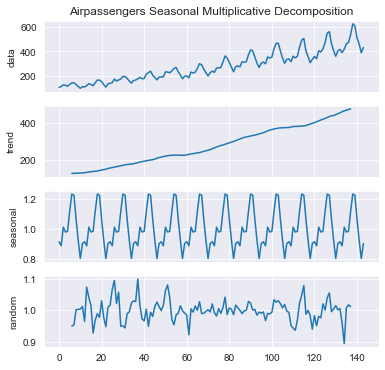

In [69]:
decomposed = arima.decompose(datasets.load_airpassengers(), 'multiplicative', m=12) #numero de pasajeros
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Airpassengers Seasonal Multiplicative Decomposition");

Esta segunda gráfica si es una serie de tiempo de componente multiplicativo. Si se desea tener aproximacion de la segunda grafica, calculo media movil del periodo en que se repiten

Si la estacionalidad es aditiva, el resultado de la resta entre la serie de tiempo original y su media movil tendrá fluctuaciones casi similares en magnitud (pues existe el error de pronóstico no correlacionado). Si es multiplicativa, entonces el resultado de la división tiene esta propiedad.

In [18]:
def movingaverage(interval, window_size): #calculando media movil. Promedios con ventana que dependera de la periodicidad de la componente estacional
    window = np.ones(int(window_size))/float(window_size) #crea vector de unos, dividido por la longitud de la ventana
    return pd.DataFrame(np.convolve(interval, window, 'same'), columns=['MA']) #funcion convolve hace producto punto. La convulacion se hace entre el intervalo y la ventana asociada

In [19]:
dates_airpassl = dates_airpass.tolist()

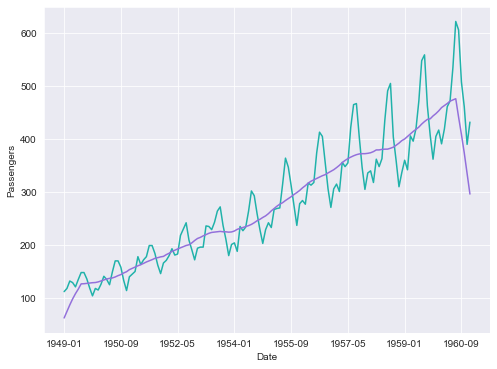

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dates_airpassl, datasets.load_airpassengers(), color='#20B2AA')
ax.plot(dates_airpassl, movingaverage(datasets.load_airpassengers(), 12), color='#9370DB'); #coloco ventana de longitud 12, por las componentes estacionales. Calculo media movil de periodo 12
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');

La linea naranja es la version suavizada del conjunto de datos, calculada con la media movil

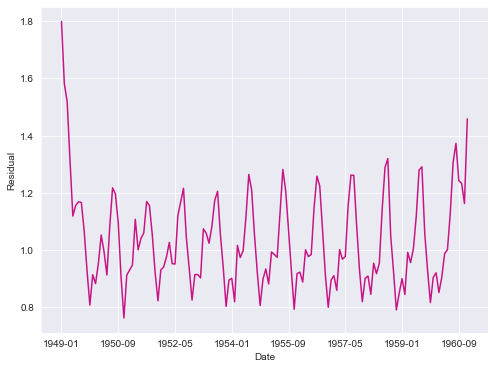

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dates_airpassl, datasets.load_airpassengers()/movingaverage(datasets.load_airpassengers(), 12).MA.values,color='#C71585'); #divido datos originales entre los datos de la media movil
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual'); #como es serie multiplica, hago la division

De la gráfica anterior se concluye que la serie temporal tiene estacionalidad multiplicativa. A continuación, se hace la prueba para un periodo 4

In [22]:
dates_beerpl = beer_aust.Quarter.tolist()

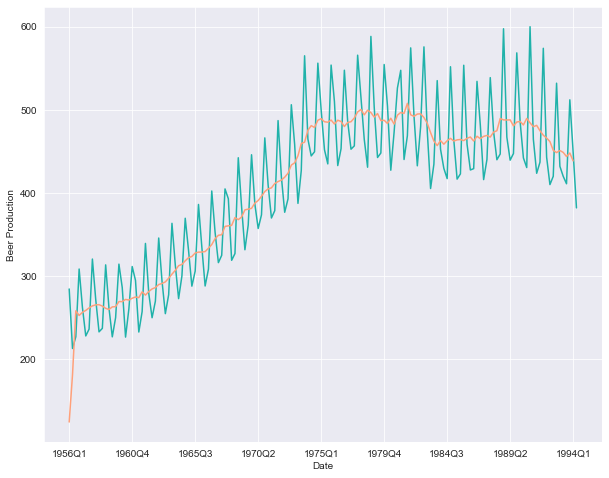

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dates_beerpl, beer_aust.beer_prod, color='#20B2AA')
ax.plot(movingaverage(beer_aust.beer_prod, 4), color='#FFA07A');
freq = int(19)
ax.set_xticks(dates_beerpl[::freq]);
ax.set_xticklabels(dates_beerpl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Beer Production');

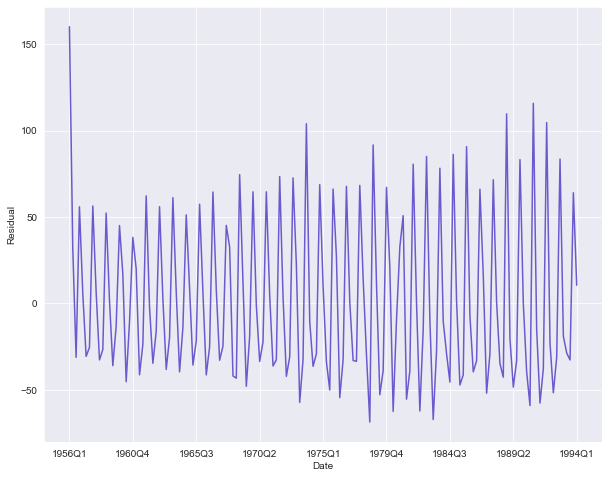

In [77]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dates_beerpl, beer_aust.beer_prod-movingaverage(beer_aust.beer_prod, 4).MA.values,color='#6A5ACD');
freq = int(19)
ax.set_xticks(dates_beerpl[::freq]);
ax.set_xticklabels(dates_beerpl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual');

En el anterior gráfico se visualiza que la amplitud se mantiene aproximadamente igual. ¿Pero qué pasa si resto la original con estacionalidad multiplicativa de la media movil? Pues se verán las variaciones en el tiempo: esto es, si calculo el residuo para una serie temporal con estacionalidad multiplicativa, la serie resultante contiene componentes estacionales cuya varianza aumenta cada periodo de frecuencia; es decir, se mantiene la variabilidad sin tendencia.

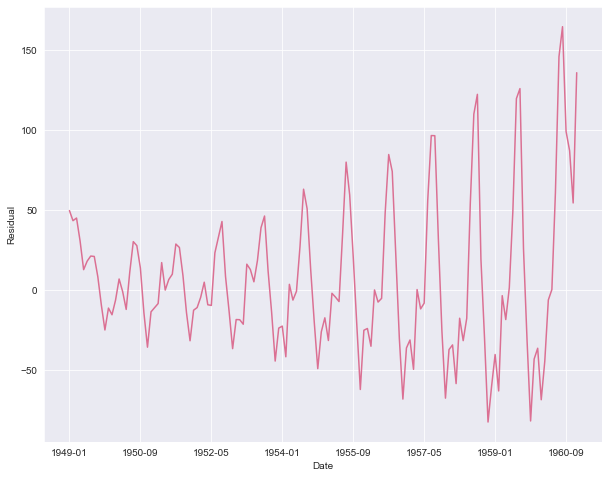

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dates_airpassl, datasets.load_airpassengers()-movingaverage(datasets.load_airpassengers(), 12).MA.values,color='#DB7093');
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual');

Una alternativa para verificar estacionalidad sin usar visualziaciones, es utilizar una prueba no paramétrica (ver Kruskal-Wallis test). Este test comprueba la correlación entre la observación real y la observación retardada. Si las observaciones son independientes entre sí, siguen una distribución $\chi^2$ 
Cuando se rechaza esta hipótesis, se confirma una autocorrelación significativa, que es señal de movimientos estacionales en la serie.

In [26]:
from scipy.stats import kruskal #con base a correlacion entre dato actual y el rezagado

def seasonality_test(series, period):
    seasonal = False
    idx = np.arange(len(series)) % period
    H_statistic, p_value = kruskal(series, idx)
    if p_value <= 0.05:
        seasonal = True
    return seasonal

In [27]:
print("Is the Air Passengers time series seasonal?:", seasonality_test(dates_airpassl, 12))

Is the Air Passengers time series seasonal?: True


C:\Users\caro_\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [28]:
print("Is the Beer production time series seasonal?:", seasonality_test(beer_aust.beer_prod, 4))

Is the Beer production time series seasonal?: False


La señal de la serie temporal anterior cuenta con una tendencia, estacionalidad y un residuo (ruido blanco). El suavizado ayuda a eliminar el componente residual y capta los componentes de tendencia y estacionalidad para la predicción de la señal.

El primer paso del modelo para incluir la media, la tendencia y los patrones no estacionales es extrapolarla mediante la suavización. El suavizado de media móvil evalúa las esperanzas $E(y_t)$ utilizando todas las observaciones anteriores, así:
$$\hat{y_t}=\frac{1}{N} \sum_{i=1}^{T}y_{t-i}$$

# Suavización exponencial de primer orden

Cada parámetro $\theta$ decrece de forma geometrica, al hacerse cada vez mas pequeños, valores muy alejados del tiempo actual, son considerados practicamente nulos y no tienen gran influencia en la suavizacion exponencial. Para que esto sea algo ponderado la sumatoria de estas potencias debe ser igual a 1.
Cuando $\lambda$=1 no tenemos practicamente suavización

In [29]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [30]:
ibm_df = pd.read_csv('datasets/ibm-common-stock-closing-prices.csv')
ibm_df.head()

,Date,IBM common stock closing prices
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


Se tomará como ejemplo el precio de cierre de las acciones de IBM para pronosticarlo utilizando el método de suavizado simple.

In [31]:
ibm_df.rename(columns={'IBM common stock closing prices': 'Close_Price'}, inplace=True)
ibm_df.head()

,Date,Close_Price
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


In [32]:
def single_exp_smoothing(x, alpha):
    F = [x[0]]
    for t in range(1, len(x)): #rango desde 1 hasta la longitud de la serie de tiempo
        F.append(alpha * x[t] + (1 - alpha) * F[t-1]) #coloco alpha porque en python hay una funcion que se llama lamba
    return F

In [33]:
ibm_df['SES0'] = single_exp_smoothing(ibm_df['Close_Price'], 0)
ibm_df['SES1'] = single_exp_smoothing(ibm_df['Close_Price'], 1)

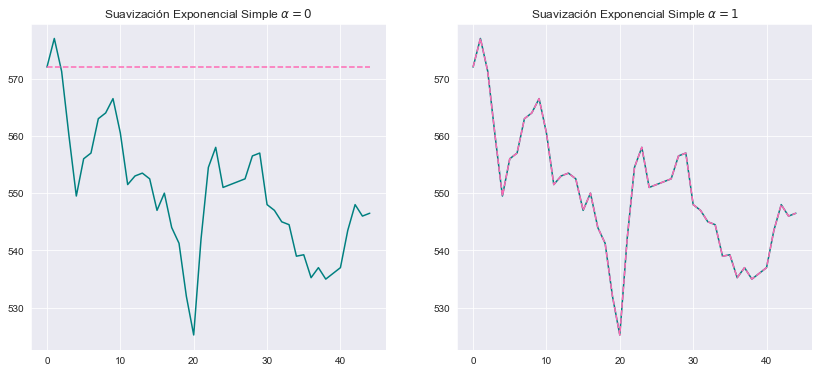

In [87]:
f, axarr = plt.subplots(1, 2, sharex=True)
f.set_size_inches(14, 6)


ibm_df['Close_Price'].iloc[:45].plot(color='#008080', linestyle = '-', ax=axarr[0])
ibm_df['SES0'].iloc[:45].plot(color='#FF69B4', linestyle = '--', ax=axarr[0])
axarr[0].set_title(r'Suavización Exponencial Simple $\alpha=0$');

ibm_df['Close_Price'].iloc[:45].plot(color='#008080', linestyle = '-', ax=axarr[1])
ibm_df['SES1'].iloc[:45].plot(color='#FF69B4', linestyle = '--', ax=axarr[1])
axarr[1].set_title(r'Suavización Exponencial Simple $\alpha=1$');

De la gráfica anterior se infiere que para $\alpha=0$, la predicción es una constante, y para $\alpha=1$, la serie pronosticada se desplaza un desfase temporal, es la misma, entonces no hay suavizacion (es la original). 

In [35]:
ibm_df['SES2'] = single_exp_smoothing(ibm_df['Close_Price'], 0.2)
ibm_df['SES6'] = single_exp_smoothing(ibm_df['Close_Price'], 0.6) #se ajusta mejor a los datos
ibm_df['SES8'] = single_exp_smoothing(ibm_df['Close_Price'], 0.8)

Con esto, busco obtener el mejor ajuste

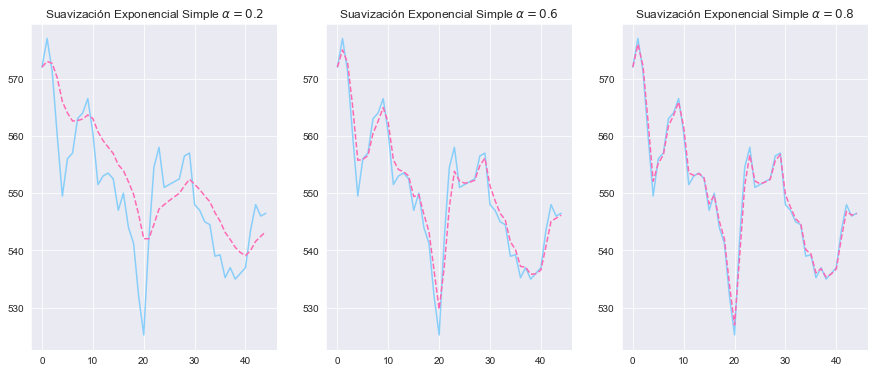

In [88]:
f, axarr = plt.subplots(1, 3, sharex=True)
f.set_size_inches(15, 6)

ibm_df['Close_Price'].iloc[:45].plot(color='#87CEFA', linestyle = '-', ax=axarr[0])
ibm_df['SES2'].iloc[:45].plot(color='#FF69B4', linestyle = '--', ax=axarr[0])
axarr[0].set_title(r'Suavización Exponencial Simple $\alpha=0.2$');

ibm_df['Close_Price'].iloc[:45].plot(color='#87CEFA', linestyle = '-', ax=axarr[1])
ibm_df['SES6'].iloc[:45].plot(color='#FF69B4', linestyle = '--', ax=axarr[1])
axarr[1].set_title(r'Suavización Exponencial Simple $\alpha=0.6$');

ibm_df['Close_Price'].iloc[:45].plot(color='#87CEFA', linestyle = '-', ax=axarr[2])
ibm_df['SES8'].iloc[:45].plot(color='#FF69B4', linestyle = '--', ax=axarr[2])
axarr[2].set_title(r'Suavización Exponencial Simple $\alpha=0.8$');

De la gráfica anterior se concluye que $\alpha$ tiene un gran impacto en la previsión; por lo tanto, obtener el valor correcto de $\alpha$ es fundamental a la hora de establecer la previsión. La precisión del modelo puede evaluarse en una muestra utilizando funciones objetivo estándar como el error cuadrático medio (MSE) o el error absoluto medio (MAD). 
$$MSE=\frac{1}{N}\sum_{i=1}^{N}\left(y_t-\tilde{y_t}\right)^2$$
$$MAD=\frac{1}{N}\sum_{i=1}^{N}\left\lvert y_t-\tilde{y_t}\right\rvert$$

Cuando alpha tiende a cero, la Var(yr) que obtengo para la suavización tiende a cero, por eso tiende a ser constante la predicción

Suavizacion de 3er orden tiene en cuenta: suavizacion de 1 er orden (valores del nivel medio) + comp estacionalidad + componente de tendencia (T). F pronostica valores constantes y S pronostica la estacionalidad